# Project for DL for CV. Part 1. Preparation.
#### Author: `Sofiia Kononovych`

In this lab I am going to begin working on my project perform EDA of the Intel Image Classification DataSet

Overall we have 24 345 images, 14 044 images in train folder, 3000 in test folder and 7301 in pred folder.

# Part 1 - EDA

#### Load and explore the data

In [128]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from torchvision import datasets, transforms
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision.io import read_image
import random
from collections import Counter
import seaborn as sns
from torch.optim.lr_scheduler import CosineAnnealingLR
import optuna
import copy
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import copy

In [129]:
!ls /kaggle/input

intel-image-classification


Structure of my Intel Image Dataset folder

```
intel-image-cls/
├── seg_train/        # Training set (with class subfolders)
│   ├── buildings/
│   ├── forest/
│   ├── glacier/
│   ├── mountain/
│   ├── sea/
│   └── street/
│
├── seg_test/         # Test set (with class subfolders)
│   ├── buildings/
│   ├── forest/
│   ├── glacier/
│   ├── mountain/
│   ├── sea/
│   └── street/
│
└── seg_pred/         # Unlabeled images for prediction/inference
    ├── img1.jpg
    ├── img2.jpg
    └── ...
```



In [130]:
# Set paths
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'
pred_dir = '/kaggle/input/intel-image-classification/seg_test/seg_pred'

# Image size
img_size = (150, 150)

Count number of classes

In [131]:
classes = sorted(os.listdir(train_dir))
print(f"Number of classes: {len(classes)}")
print(f"Classes: {classes}")

Number of classes: 6
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Check image format

In [132]:
sample_path = os.path.join(train_dir, classes[0], os.listdir(os.path.join(train_dir, classes[0]))[0])
img = Image.open(sample_path)
print(f"Image size: {img.size}, mode: {img.mode}")

Image size: (150, 150), mode: RGB


Check for balanced data in each class

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


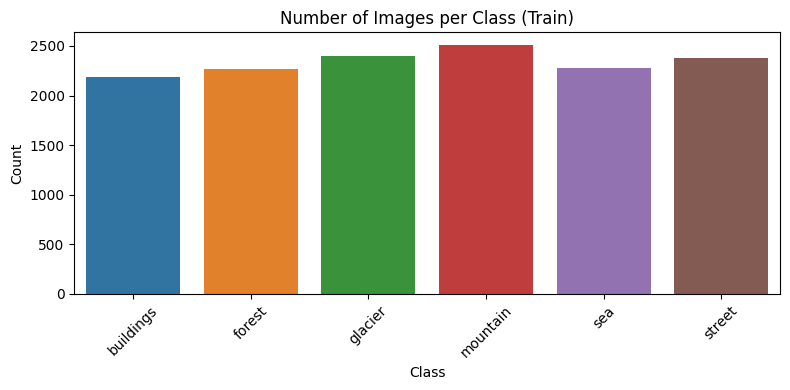

In [133]:
# Fast count: number of files per class in seg_train
class_counts = {
    cls: len(os.listdir(os.path.join(train_dir, cls)))
    for cls in sorted(os.listdir(train_dir))
}

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Number of Images per Class (Train)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- From the plot above we can see that the dataset seems to be relatevely balanced -> this means accuracy is decent metric for evaluation.
- We will add f1 later in Part 3.

#### Visualize 3 Random Images Per Class

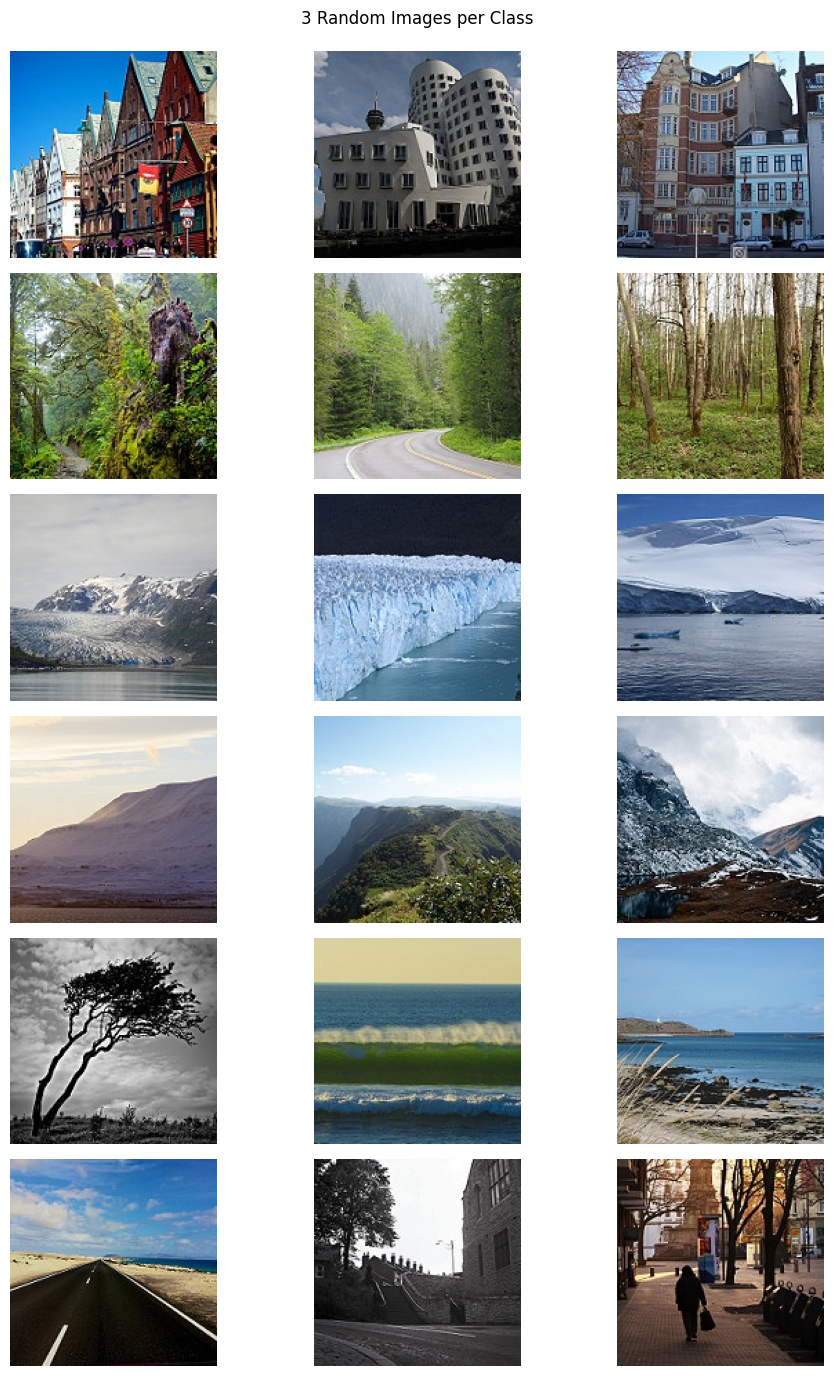

In [134]:
fig, axes = plt.subplots(nrows=len(classes), ncols=3, figsize=(10, 14))
fig.suptitle("3 Random Images per Class")

for i, cls in enumerate(classes):
    class_folder = os.path.join(train_dir, cls)
    sample_imgs = random.sample(os.listdir(class_folder), 3)
    for j, img_name in enumerate(sample_imgs):
        img_path = os.path.join(class_folder, img_name)
        img = Image.open(img_path).convert("RGB")
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        if j == 0:
            axes[i, j].set_ylabel(cls, rotation=0, size='large', labelpad=40)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

####Turning raw images into datasets

In [135]:
full_train_dataset = datasets.ImageFolder(train_dir)

Find out the length of train set

In [136]:
len(full_train_dataset)

14034

Split on test and validation

In [186]:
# Split into train/val
val_size = int(0.2 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

#### Tensor transformation (+ normalizing)

In [188]:
# Define separate transforms
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), shear=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],       # this normalisation is more effective than classic one with 0.5 as it comes from imageNet
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

At the end aftre exploring different augmentation techniques I decided to use basic augmentation : simple is good axtually. Harder augmentation will be used when using dynamic augmentation and we will talk about it later.

Apply transforms after splitting.


In [189]:
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

Load and transform test dataset too.

In [190]:
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)


Special handling of unlabeled data

In [141]:
class UnlabeledImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith(('.jpg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

In [142]:
# pred_dataset = UnlabeledImageDataset(pred_dir, transform=val_transform)

Check the length of each dataset

In [143]:
# Summary
print(f"Train dataset: {len(train_dataset)}")
print(f"Val dataset:   {len(val_dataset)}")
print(f"Test dataset:  {len(test_dataset)}")
# print(f"Pred dataset:  {len(pred_dataset)}")

Train dataset: 11228
Val dataset:   2806
Test dataset:  3000


#### Create DataLoaders

batch size = 32 - considered to be optimal

In [144]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [145]:
# check for classes to  be correct,y displayed in dataloaders
class_names = train_dataset.dataset.classes
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Check if batch shape and labels correctly set

In [146]:
images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)
print("Label indices:", labels)

Batch shape: torch.Size([32, 3, 224, 224])
Label indices: tensor([4, 1, 1, 1, 2, 1, 2, 4, 1, 0, 3, 2, 3, 4, 2, 1, 5, 0, 2, 4, 1, 4, 5, 0,
        5, 4, 0, 4, 3, 2, 0, 5])


#### Visualise batch


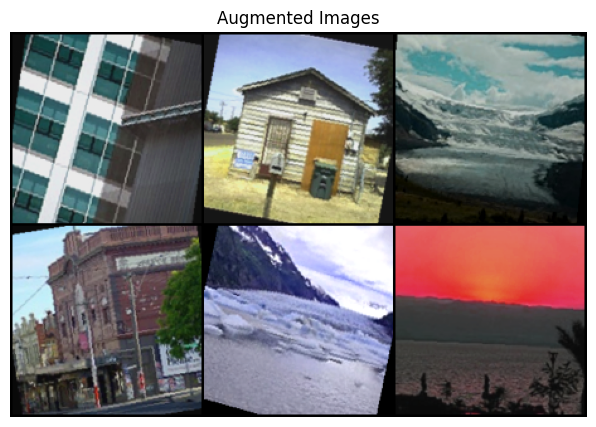

In [147]:
temp_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
temp_loader = DataLoader(temp_dataset, batch_size=6, shuffle=True)

images, labels = next(iter(temp_loader))

mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
images = images * std + mean

grid = make_grid(images, nrow=3).permute(1, 2, 0).clamp(0, 1)
plt.figure(figsize=(10, 5))
plt.imshow(grid)
plt.title("Augmented Images")
plt.axis("off")
plt.show()

## Part 2 - building basic CNN

### Realisation of simple CNN architecture

Below is the simplest model I have built.

In [148]:
class CNN(nn.Module):
    def __init__(self, num_classes=6):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(32 * 75 * 75, 128)  # assuming input size is 150x150
        self.fc2 = nn.Linear(128, num_classes)

        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv → ReLU → Pool
        x = torch.flatten(x, 1)              # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


### Loss Function & Optimizer

Then I try experimenting with different model setups, and wdefine few more core models for testing.

In [149]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bn1   = nn.BatchNorm2d(32)
        self.bn2   = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64 * 37 * 37, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [150]:
class AdvancedCNN(nn.Module):
    def __init__(self, start_c=32, pooling='max', num_classes=6):
        super(AdvancedCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bn1   = nn.BatchNorm2d(32)
        self.bn2   = nn.BatchNorm2d(64)
        self.bn3   = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128 * 18 * 18, 256)
        # self.ln1 = nn.LayerNorm(256) 
        self.fc2 = nn.Linear(256, num_classes)
        
        self.dropout1 = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        
        return x

In [151]:
class SuperCNN(nn.Module):
    def __init__(self, start_c=32, pooling="max", num_classes=6):
        super(SuperCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, start_c, 3, padding=1)
        self.conv2 = nn.Conv2d(start_c, start_c * 2, 3, padding=1)
        self.conv3 = nn.Conv2d(start_c * 2, start_c * 4, 3, padding=1)
        self.conv4 = nn.Conv2d(start_c * 4, start_c * 4, 3, padding=1) 

        self.pool = nn.MaxPool2d(2, 2) if pooling == "max" else nn.AvgPool2d(2, 2)

        self.bn1 = nn.BatchNorm2d(start_c)
        self.bn2 = nn.BatchNorm2d(start_c * 2)
        self.bn3 = nn.BatchNorm2d(start_c * 4)
        self.bn4 = nn.BatchNorm2d(start_c * 4)

        self.fc1 = nn.Linear(9 * 9 * start_c * 4, 512)  # After 4 poolings: 150→75→37→18→9
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

        self.ln1 = nn.LayerNorm(512)  

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 150 → 75
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 75 → 37
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 37 → 18
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # 18 → 9

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.ln1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = self.dropout(x)
        x = F.relu(x)

        x = self.fc3(x)
        return x

In [152]:
# Ініціалізація моделі
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AdvancedCNN(num_classes=len(class_names)).to(device)
print(model)

AdvancedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=41472, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
)


I choose CrossEntropyLoss as it is basic and reliable, optimiser is Adam - from experience it works well with classification tasks , later we will try AdamW - advanced version of Adam.

In [153]:
# Налаштування функції втрат, оптимізатора та гіперпараметрів
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                       lr=1e-4,
                       betas=(0.9, 0.999),
                       weight_decay=1e-4)
num_epochs = 20

### My training pipeline

(it is same for almost all trainings, only altered slightly, so I will ommit this code sometimes)

In [154]:
# train_loss_hist, val_loss_hist = [], []
# train_acc_hist, val_acc_hist = [], []

# for epoch in range(num_epochs):
#     # Training
#     model.train()
#     running_loss, correct, total = 0, 0, 0
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         loss = loss_function(outputs, labels)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         _, preds = torch.max(outputs, 1)
#         correct += (preds == labels).sum().item()
#         total += labels.size(0)

#     train_loss = running_loss / len(train_loader)
#     train_acc = correct / total
#     train_loss_hist.append(train_loss)
#     train_acc_hist.append(train_acc)

#     # Validation
#     model.eval()
#     val_loss, val_correct, val_total = 0, 0, 0
#     with torch.no_grad():
#         for images, labels in val_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             loss = loss_function(outputs, labels)

#             val_loss += loss.item()
#             _, preds = torch.max(outputs, 1)
#             val_correct += (preds == labels).sum().item()
#             val_total += labels.size(0)

#     val_loss = val_loss / len(val_loader)
#     val_acc = val_correct / val_total
#     val_loss_hist.append(val_loss)
#     val_acc_hist.append(val_acc)

#     print(f"Epoch [{epoch+1}/{num_epochs}] → "
#           f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, "
#           f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# # Plot Accuracy and Loss
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(train_acc_hist, label='Train Acc')
# plt.plot(val_acc_hist, label='Val Acc')
# plt.title("Accuracy")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(train_loss_hist, label='Train Loss')
# plt.plot(val_loss_hist, label='Val Loss')
# plt.title("Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()

# plt.tight_layout()
# plt.show()

#### Training without scheduler and early stopping

Results I got are below (these models were given 150*150 images):

The simplest model (even this one overfits)

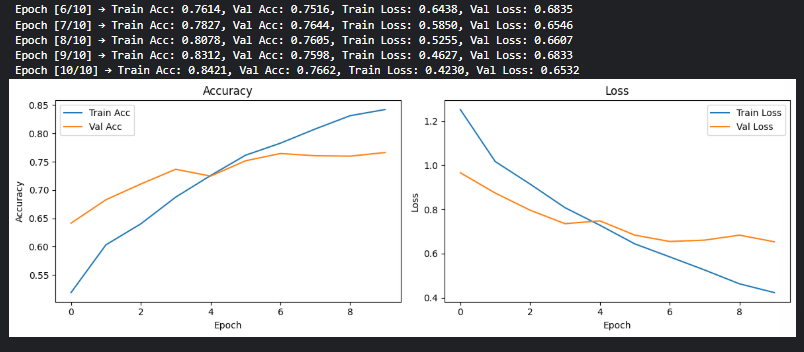


Simple CNN (overfits badly)

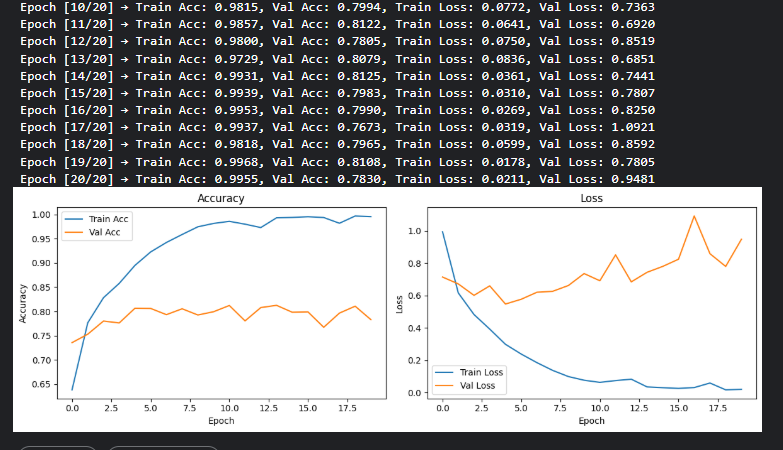

**Advanced CNN (best so far) - current version**

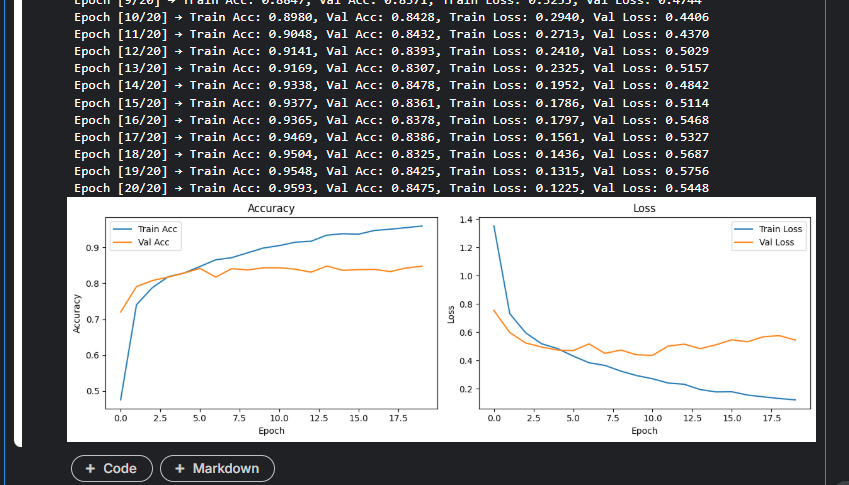

Advanced CNN (dropout increased, added one more - 4th - linear layer)

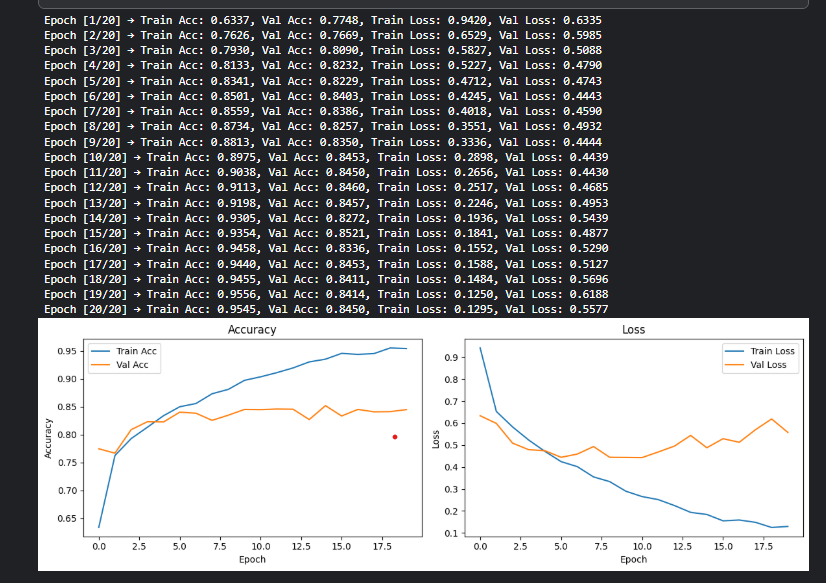

SuperCNN (dropout increased, added one more - 4th - linear layer)

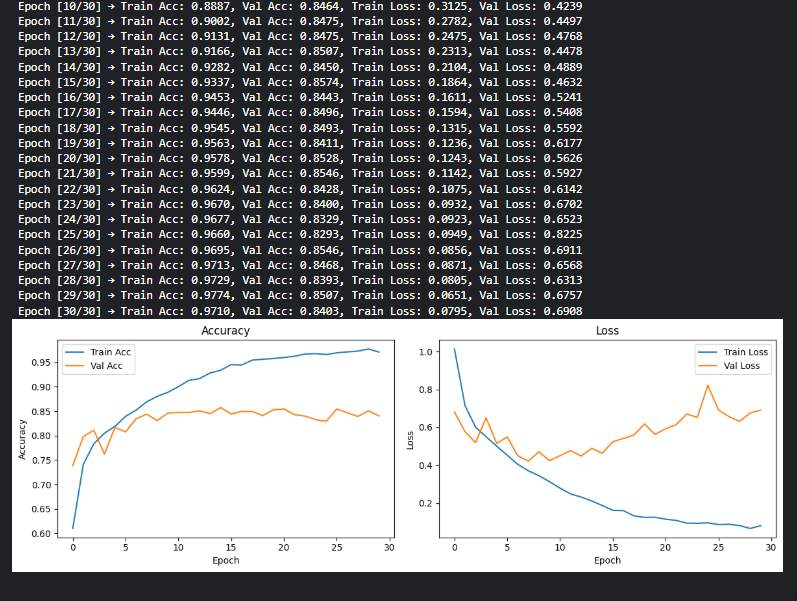

Simpler --> better in my case and I choose to use **AdvancedCNN**

Also I changed activation function to **Gelu** - often used in larger models, but still seemed to help me with overfitting a bit. Though it is more computationally expensive:

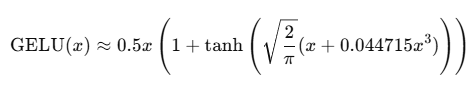

Now let`s try to use scheduler and see what improves.

In [155]:
# different schedulers below

scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=5
# )

# scheduler = torch.optim.lr_scheduler.CyclicLR(
#     optimizer,
#     base_lr=1e-5,
#     max_lr=1e-3,
#     step_size_up=2000,
#     mode='triangular', 
#     cycle_momentum=False
# )

# for early stopping
early_stop_patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_wts = copy.deepcopy(model.state_dict())

### Scheduler 

Now let`s perform modified training: 

**with scheduler only** (pipeline is almost the same as before)

**Results different schedulers showed us :** 

**ReduceLROnPlateau**

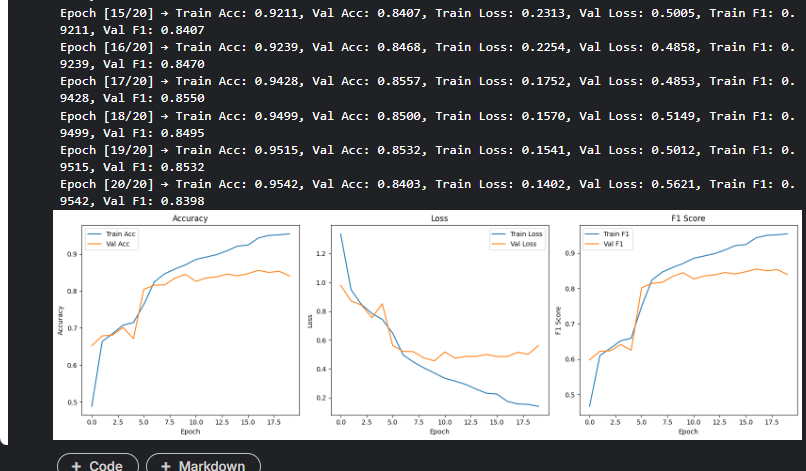

**CosineAnnealingLR**

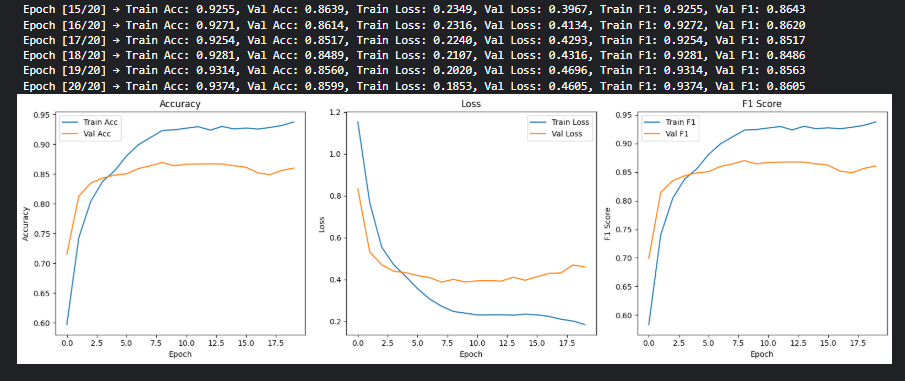


**CyclicLR**

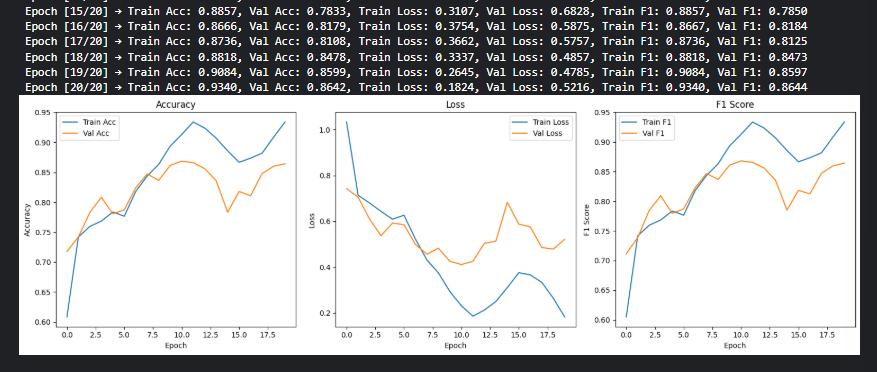

- **Best scheduler** --> It is quite hard to say which one is best, as every showed its pros and cons 
- talking  about val accuracy - **CyclingLR** showed the best one(0,86), though we see its training pipeline is not stable
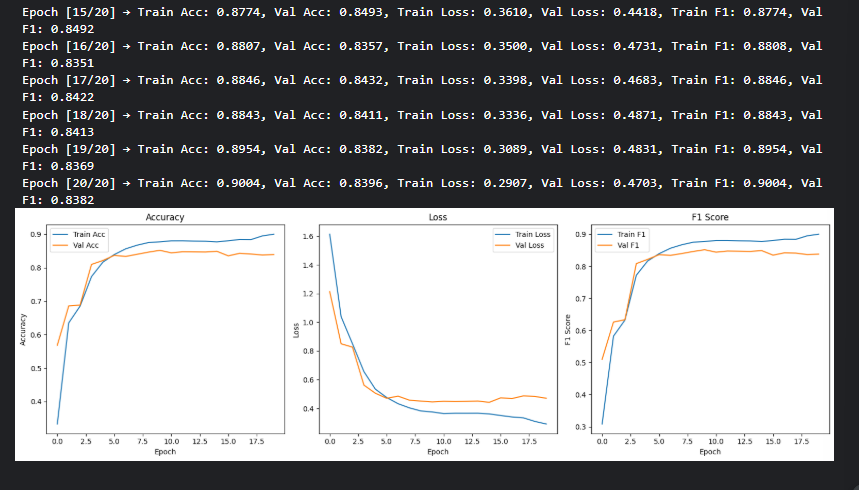

with early stopping and cyclinglr

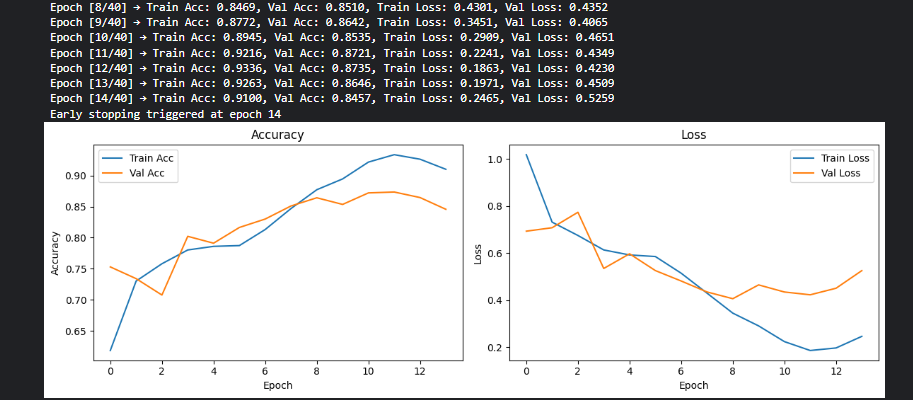

We see not a bad result with early stopping, but I decided to train my model at least 15-20 epoch to see the tendency and fallbacks.

### Conclusions of Part 3 and difficulties

- We have successfully managed to define the most optimal CNN model - AdvancedCNN with 3 convolutional layers, GELU activation, max pooling, 2 fully connected layers with dropout 0.3 (regularization)
  
- We still have overfitting and I think this comes as a problem of my data - some of the classes are very similiar (street/building , mountain/glacier) 

  
- We have to find the best trade off between accuracy/f1 and overfitting level, and if I reduce overfitting the model performance is worse as model is less complex

- more different regularisation techniques are planned to be tested to address the issue

- overall, best performance 0.86 (accuracy) on validation is a decent result.

# Part 3 - Hyperparameter Optimization of a Neural Network Model

### Manual Optimization

*Search for the best values depending on loss, accuracy, fc1*

Manual optimization included retraining different models with alteration of their parameters and comparing model training results.

I considered the experience on previous steps(look at evaluation plots) and used training pipeline from Part 2, results so far: 

- Number of Convolutional Layers - 3
- LR - 1e-4
- Dropout - 0.3 - 0.4
- batch size - 32
- optimizer - Adam
- weight decay - 1e-4
- fully-connected - 2 layers
  

### Automatic optimization using Optuna


*Optuna works by suggesting hyperparameter values for each trial using intelligent sampling strategies like Tree-structured Parzen Estimators (TPE). For each trial, it builds and trains a model with those parameters, evaluates performance (e.g., F1-score), and uses this feedback to guide future trials toward better regions of the hyperparameter space.It also supports early stopping (pruning) of poor-performing trials to save computation, making it highly efficient.*


Optuna setup:

In [156]:
# Fix randomness
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def build_model(trial, num_classes=6):
    num_conv_layers = trial.suggest_int("num_conv_layers", 2, 3)
    dropout = trial.suggest_float("dropout", 0.2, 0.4)
    fc1_size = trial.suggest_categorical("fc1_size", [128, 256, 512])
    fc2_size = trial.suggest_categorical("fc2_size", [64, 128])

# setup model with dynamical parameters for Optuna

    class CNN(nn.Module):
        def __init__(self):
            super().__init__()
            self.pool = nn.MaxPool2d(2, 2)

            self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
            self.bn1 = nn.BatchNorm2d(32)

            self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
            self.bn2 = nn.BatchNorm2d(64)

            self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
            self.bn3 = nn.BatchNorm2d(128)

            self.num_conv_layers = num_conv_layers
            self.dropout = nn.Dropout(dropout)

            # Dummy pass to compute flatten dim
            dummy_input = torch.zeros(1, 3, 150, 150)
            with torch.no_grad():
                out = self._forward_features(dummy_input)
                self.flatten_dim = out.view(1, -1).shape[1]

            self.fc1 = nn.Linear(self.flatten_dim, fc1_size)
            self.fc2 = nn.Linear(fc1_size, fc2_size)
            self.fc3 = nn.Linear(fc2_size, num_classes)

        def _forward_features(self, x):
            x = self.pool(F.relu(self.bn1(self.conv1(x))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            if self.num_conv_layers == 3:
                x = self.pool(F.relu(self.bn3(self.conv3(x))))
            return x

        def forward(self, x):
            x = self._forward_features(x)
            x = torch.flatten(x, 1)
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    return CNN().to(device)


In [157]:
def objective(trial):
    model = build_model(trial).to(device)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    best_val_f1 = 0

    for epoch in range(20): 
        model.train()
        all_preds, all_labels = [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        best_val_f1 = max(best_val_f1, val_f1)

        # pruning
        trial.report(val_f1, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_val_f1

In [158]:
# Run Optuna
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=30)

# # Show best
# print("\nBest Trial:")
# for key, val in study.best_trial.params.items():
#     print(f"  {key}: {val}")
# print("Best Val F1:", study.best_value)

**Result :** 

Best F1 Score: 0.8501361524130228  
Best hyperparameters we got:
  - num_conv_layers: 3  
  - dropout: 0.30  
  - fc1_size: 512  
  - fc2_size: 128  
  - lr: 0.000511839573506781

### Most productive model
based on what our  optimization showed us now lets define the best model

In [159]:
class AdvancedCNN(nn.Module):
    def __init__(self, start_c=32, pooling='max', num_classes=6):
        super(AdvancedCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)  

        self.fc1 = nn.Linear(256 * 14 * 14, 256)  
        self.fc2 = nn.Linear(256, num_classes)

        self.dropout1 = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.pool(F.gelu(self.bn1(self.conv1(x))))
        x = self.pool(F.gelu(self.bn2(self.conv2(x))))
        x = self.pool(F.gelu(self.bn3(self.conv3(x))))
        x = self.pool(F.gelu(self.bn4(self.conv4(x))))  

        x = torch.flatten(x, 1)
        x = F.gelu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x) 

        return x

In [160]:
# Model initialisation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AdvancedCNN(num_classes=len(class_names)).to(device)
print(model)

AdvancedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=50176, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
)


In [161]:
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(),
                       lr=1e-4,
                       betas=(0.9, 0.999),
                       weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

# scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

num_epochs = 20

Epoch [1/20] → Train Acc: 0.6772, Val Acc: 0.7830, Train Loss: 0.8870, Val Loss: 0.6113, Train F1: 0.6763, Val F1: 0.7817
Epoch [2/20] → Train Acc: 0.7782, Val Acc: 0.8086, Train Loss: 0.6159, Val Loss: 0.5348, Train F1: 0.7781, Val F1: 0.8079
Epoch [3/20] → Train Acc: 0.8141, Val Acc: 0.8019, Train Loss: 0.5254, Val Loss: 0.5676, Train F1: 0.8141, Val F1: 0.8027
Epoch [4/20] → Train Acc: 0.8359, Val Acc: 0.8375, Train Loss: 0.4578, Val Loss: 0.4722, Train F1: 0.8359, Val F1: 0.8371
Epoch [5/20] → Train Acc: 0.8594, Val Acc: 0.8133, Train Loss: 0.3946, Val Loss: 0.5491, Train F1: 0.8593, Val F1: 0.8154
Epoch [6/20] → Train Acc: 0.8684, Val Acc: 0.8172, Train Loss: 0.3608, Val Loss: 0.5304, Train F1: 0.8683, Val F1: 0.8182
Epoch [7/20] → Train Acc: 0.8815, Val Acc: 0.8354, Train Loss: 0.3247, Val Loss: 0.4424, Train F1: 0.8815, Val F1: 0.8350
Epoch [8/20] → Train Acc: 0.8975, Val Acc: 0.8542, Train Loss: 0.2823, Val Loss: 0.4369, Train F1: 0.8974, Val F1: 0.8548
Epoch [9/20] → Train Acc

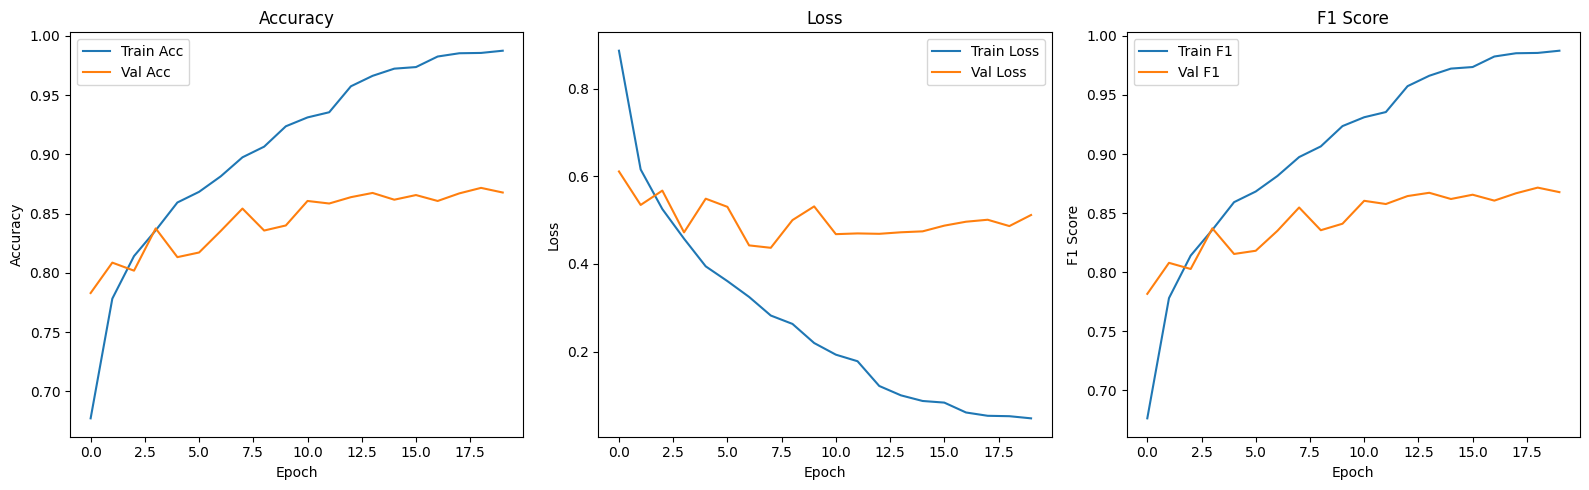

In [162]:
train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []
train_f1_hist, val_f1_hist = [], [] 
best_val_f1 = 0

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()        

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_f1 = f1_score(all_labels, all_preds, average='weighted')  

    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    train_f1_hist.append(train_f1)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    scheduler.step(val_loss)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_manual.pth")

    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_f1 = f1_score(all_labels, all_preds, average='weighted')  
    
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)
    val_f1_hist.append(val_f1)


    print(f"Epoch [{epoch+1}/{num_epochs}] → "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")

torch.save(model.state_dict(), "last_model.pth")

# Plot Accuracy, Loss, and F1-Score
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.plot(train_acc_hist, label='Train Acc')
plt.plot(val_acc_hist, label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_f1_hist, label='Train F1')
plt.plot(val_f1_hist, label='Val F1')
plt.title("F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()

plt.tight_layout()
plt.show()

### Evaluation of results

**Confusion matrix on training**

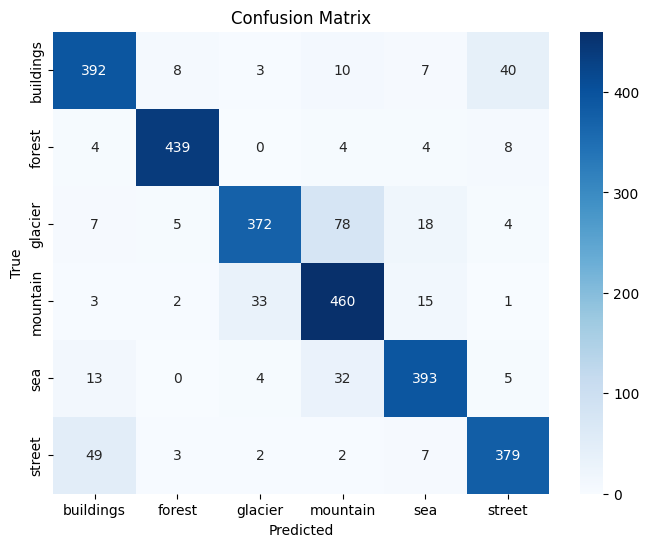

In [163]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Test dataset at last!

In [164]:
model = AdvancedCNN(num_classes=len(class_names))
model.load_state_dict(torch.load("best_manual.pth"))
model.to(device)
model.eval()

/tmp/ipykernel_31/445400780.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_manual.pth"))


AdvancedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=50176, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
)

Evaluating on test set: 100%|██████████| 94/94 [00:15<00:00,  6.25it/s]



Classification Report:
              precision    recall  f1-score   support

   buildings       0.80      0.75      0.77       437
      forest       0.83      0.95      0.89       474
     glacier       0.83      0.69      0.76       553
    mountain       0.72      0.79      0.75       525
         sea       0.77      0.79      0.78       510
      street       0.81      0.78      0.79       501

    accuracy                           0.79      3000
   macro avg       0.79      0.79      0.79      3000
weighted avg       0.79      0.79      0.79      3000



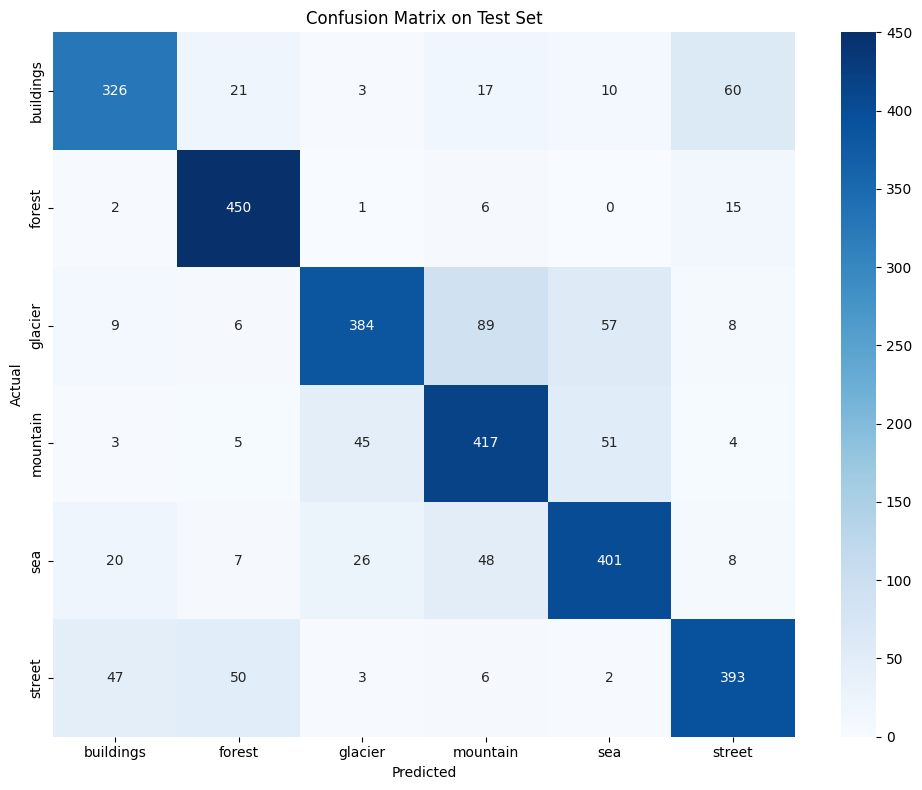


Test Accuracy: 0.7903
Test Weighted F1 Score: 0.7891


In [165]:
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating on test set"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

# Accuracy & F1
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Test Weighted F1 Score: {f1:.4f}")

### Conclusions of Part 3 and difficulties

- our final model in part 3 is AdvancedCNN - with 4-layer cnn, GELU activations, batch normalization, max pooling, dropout 0.3(for regularisation).

- model is very confident with training set but failed to maintain the same confidence with unseen test data -> signs of overfitting.

- the main challange I faced during training my model training was its overfitting, I tried to reduce it by using various regularisation methods. Best validation f1 I got was 0.87 

- On the test dataset, the model reached a final F1-score of 0.79 -  which is not bad considering we have large dataset and some classes (mountain/glacier, street/building) turned out to be similiar for model.

# Part 4. Transfer learning & Fine-tuning

### ResNet Model

#### Initialising 

In [191]:
from torchvision import models

resnet = models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Modify the output layer

In [192]:
num_classes = 6
in_features = resnet.fc.in_features  # 2048 for resnet50
resnet.fc = nn.Sequential(
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, num_classes)
)

model = resnet.to(device)

#### Training

In [193]:
# Freeze all layers at the start
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
    

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW([
    {'params': model.layer1.parameters(), 'lr': 1e-5},
    {'params': model.layer2.parameters(), 'lr': 1e-5},
    {'params': model.layer3.parameters(), 'lr': 3e-5},
    {'params': model.layer4.parameters(), 'lr': 5e-5},
    {'params': model.fc.parameters(), 'lr': 1e-4},
], weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

# scheduler = torch.optim.lr_scheduler.CyclicLR(
#     optimizer,
#     base_lr=1e-5,
#     max_lr=1e-3,
#     step_size_up=2000,
#     mode='triangular', 
#     cycle_momentum=False
# )

num_epochs = 20

**Set parameters for unfreezing the model**

In [194]:
def unfreeze_block(model, block_name):
    for name, param in model.named_parameters():
        if block_name in name:
            param.requires_grad = True

unfreeze_schedule = {
    5: 'layer4', 
    10: 'layer3',
    15: 'layer2'
    # layer 1 features in ResNet seem to be already good enough to capture patterns
}

Epoch [1/20] → Train Acc: 0.7349, Val Acc: 0.8763, Train Loss: 0.9310, Val Loss: 0.4598, Train F1: 0.7366, Val F1: 0.8762
Epoch [2/20] → Train Acc: 0.8612, Val Acc: 0.8909, Train Loss: 0.4477, Val Loss: 0.3388, Train F1: 0.8611, Val F1: 0.8911
Epoch [3/20] → Train Acc: 0.8750, Val Acc: 0.8888, Train Loss: 0.3716, Val Loss: 0.3107, Train F1: 0.8749, Val F1: 0.8880
Epoch [4/20] → Train Acc: 0.8862, Val Acc: 0.8949, Train Loss: 0.3349, Val Loss: 0.2929, Train F1: 0.8861, Val F1: 0.8947
Epoch [5/20] → Train Acc: 0.8888, Val Acc: 0.8977, Train Loss: 0.3182, Val Loss: 0.2810, Train F1: 0.8888, Val F1: 0.8973
Unfroze block: layer4
Epoch [6/20] → Train Acc: 0.9095, Val Acc: 0.9323, Train Loss: 0.2525, Val Loss: 0.1987, Train F1: 0.9094, Val F1: 0.9322
Epoch [7/20] → Train Acc: 0.9574, Val Acc: 0.9287, Train Loss: 0.1255, Val Loss: 0.2106, Train F1: 0.9574, Val F1: 0.9285
Epoch [8/20] → Train Acc: 0.9786, Val Acc: 0.9262, Train Loss: 0.0687, Val Loss: 0.2354, Train F1: 0.9786, Val F1: 0.9262
Ep

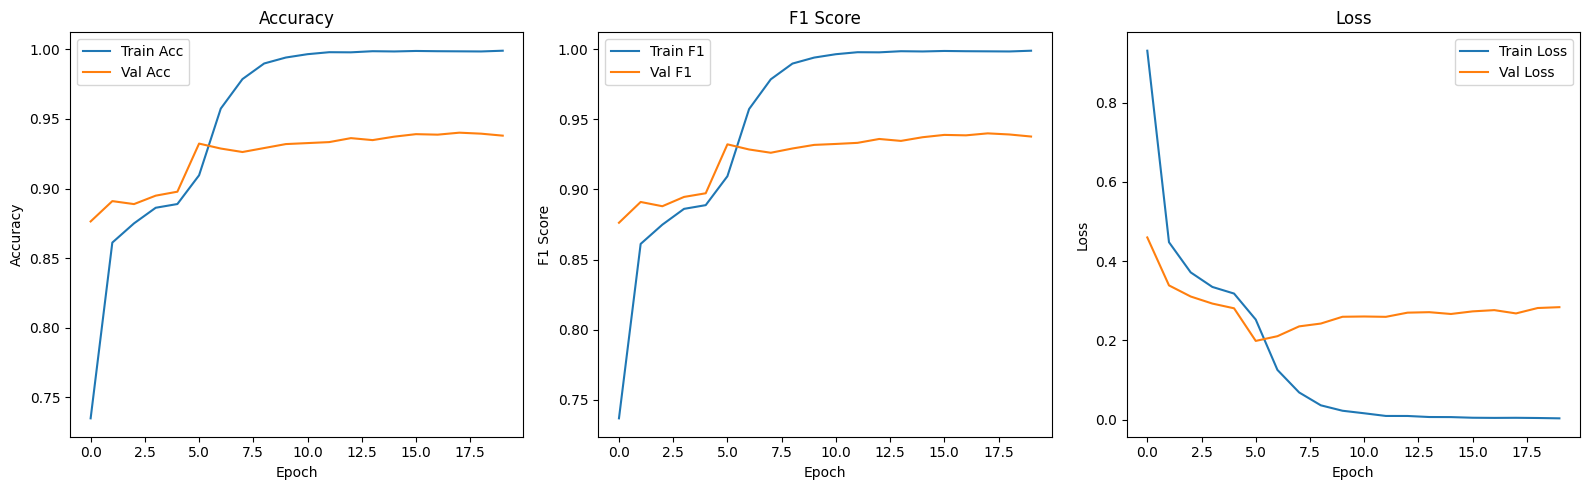

In [195]:
train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []
train_f1_hist, val_f1_hist = [], []
best_val_f1 = 0

for epoch in range(num_epochs):
    if epoch in unfreeze_schedule:
        unfreeze_block(model, unfreeze_schedule[epoch])
        print(f"Unfroze block: {unfreeze_schedule[epoch]}")

    model.train()
    running_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_f1 = f1_score(all_labels, all_preds, average='weighted')

    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    train_f1_hist.append(train_f1)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    all_preds, all_labels, all_images = [], [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(images.cpu())


    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)
    val_f1_hist.append(val_f1)

    scheduler.step(val_loss)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_resnet.pth")

    print(f"Epoch [{epoch+1}/{num_epochs}] → "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")


plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.plot(train_acc_hist, label='Train Acc')
plt.plot(val_acc_hist, label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_f1_hist, label='Train F1')
plt.plot(val_f1_hist, label='Val F1')
plt.title("F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


plt.tight_layout()
plt.show()

unfreezing 5-10-15 epoches

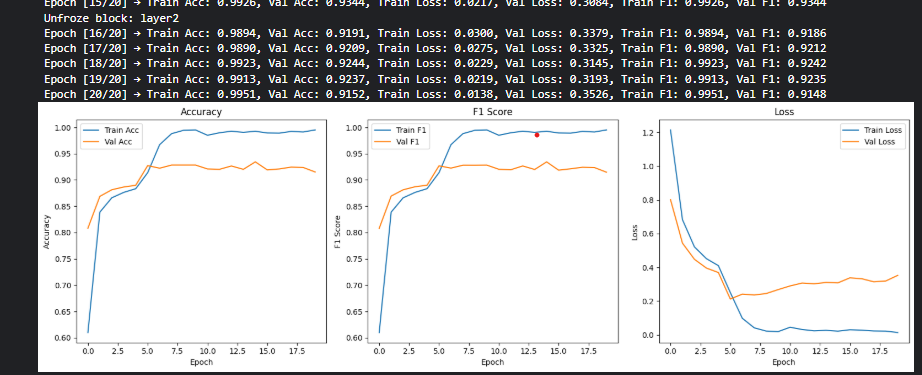

unfreezing 3-6-10 epoches

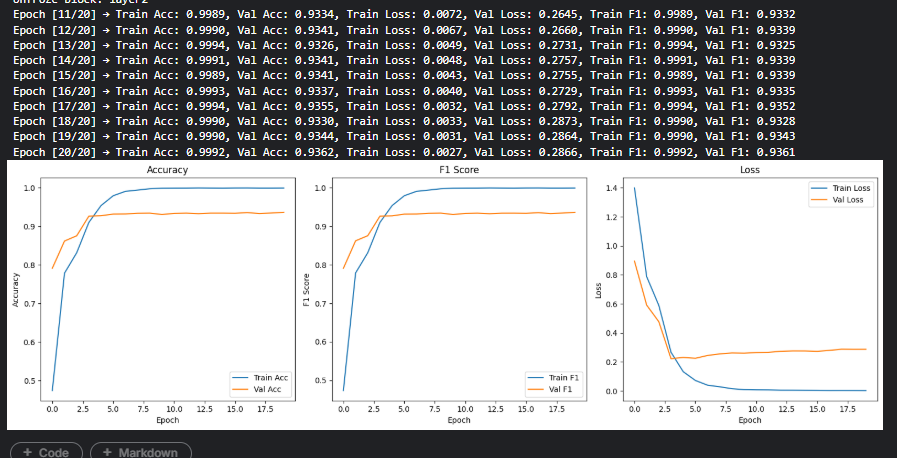


unfreezing 1-3-6 epoches - showed more overfitting

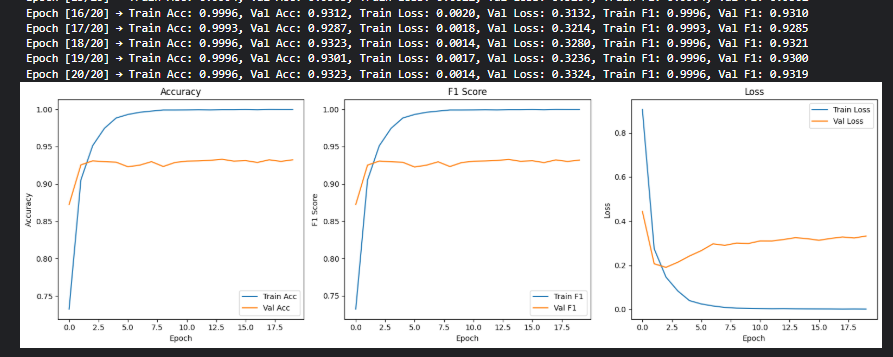

Insight : the earlier I unfreeze, the more plateau like training we have - not very good practice for my type of data.


#### My unfreezing techniques and insights: 

- Model starts overfitting from early epoches -> so lets try unfreezing backbone with very little lr at the beginning and then sequentually increase lr, lr for fully connected remains the same of course (1e-4).

- the influence of unfreezing is not that radical for my dataset, but still it was decided to stay with 5-10-15 unfreezing techique.

#### Dynamic Augmentation

In [180]:
# Split into train/val
val_size = int(0.2 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [181]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Light transforms
light_augment = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Heavy transforms 
heavy_augment = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

Using light augmentations (warm-up)


Epoch 1/20: 100%|██████████| 351/351 [00:21<00:00, 16.71it/s]


Epoch [1/20] → Train Acc: 0.7240, Val Acc: 0.8646, Train Loss: 0.9441, Val Loss: 0.4659, Train F1: 0.7265, Val F1: 0.8635
Using light augmentations (warm-up)


Epoch 2/20: 100%|██████████| 351/351 [00:15<00:00, 22.87it/s]


Epoch [2/20] → Train Acc: 0.8656, Val Acc: 0.8934, Train Loss: 0.4387, Val Loss: 0.3311, Train F1: 0.8656, Val F1: 0.8938
Using light augmentations (warm-up)


Epoch 3/20: 100%|██████████| 351/351 [00:15<00:00, 23.19it/s]


Epoch [3/20] → Train Acc: 0.8815, Val Acc: 0.8977, Train Loss: 0.3518, Val Loss: 0.2955, Train F1: 0.8817, Val F1: 0.8973
Using light augmentations (warm-up)


Epoch 4/20: 100%|██████████| 351/351 [00:14<00:00, 23.65it/s]


Epoch [4/20] → Train Acc: 0.8896, Val Acc: 0.8984, Train Loss: 0.3222, Val Loss: 0.2845, Train F1: 0.8896, Val F1: 0.8979
Using light augmentations (warm-up)


Epoch 5/20: 100%|██████████| 351/351 [00:15<00:00, 22.86it/s]


Epoch [5/20] → Train Acc: 0.8935, Val Acc: 0.9031, Train Loss: 0.3105, Val Loss: 0.2716, Train F1: 0.8934, Val F1: 0.9028
Using heavy augmentations (main training)
Unfroze: layer4


Epoch 6/20: 100%|██████████| 351/351 [00:15<00:00, 22.91it/s]


Epoch [6/20] → Train Acc: 0.9105, Val Acc: 0.9366, Train Loss: 0.2540, Val Loss: 0.1975, Train F1: 0.9104, Val F1: 0.9364
Using heavy augmentations (main training)


Epoch 7/20: 100%|██████████| 351/351 [00:15<00:00, 23.22it/s]


Epoch [7/20] → Train Acc: 0.9568, Val Acc: 0.9326, Train Loss: 0.1264, Val Loss: 0.1981, Train F1: 0.9567, Val F1: 0.9325
Using heavy augmentations (main training)


Epoch 8/20: 100%|██████████| 351/351 [00:15<00:00, 22.52it/s]


Epoch [8/20] → Train Acc: 0.9800, Val Acc: 0.9312, Train Loss: 0.0630, Val Loss: 0.2280, Train F1: 0.9800, Val F1: 0.9309
Using heavy augmentations (main training)


Epoch 9/20: 100%|██████████| 351/351 [00:16<00:00, 20.75it/s]


Epoch [9/20] → Train Acc: 0.9909, Val Acc: 0.9355, Train Loss: 0.0318, Val Loss: 0.2377, Train F1: 0.9909, Val F1: 0.9352
Using heavy augmentations (main training)


Epoch 10/20: 100%|██████████| 351/351 [00:15<00:00, 22.38it/s]


Epoch [10/20] → Train Acc: 0.9930, Val Acc: 0.9376, Train Loss: 0.0260, Val Loss: 0.2599, Train F1: 0.9930, Val F1: 0.9375
Using heavy augmentations (main training)
Unfroze: layer3


Epoch 11/20: 100%|██████████| 351/351 [00:17<00:00, 20.64it/s]


Epoch [11/20] → Train Acc: 0.9963, Val Acc: 0.9412, Train Loss: 0.0148, Val Loss: 0.2460, Train F1: 0.9963, Val F1: 0.9411
Using heavy augmentations (main training)


Epoch 12/20: 100%|██████████| 351/351 [00:16<00:00, 20.80it/s]


Epoch [12/20] → Train Acc: 0.9980, Val Acc: 0.9405, Train Loss: 0.0098, Val Loss: 0.2495, Train F1: 0.9980, Val F1: 0.9404
Using heavy augmentations (main training)


Epoch 13/20: 100%|██████████| 351/351 [00:17<00:00, 19.80it/s]


Epoch [13/20] → Train Acc: 0.9971, Val Acc: 0.9348, Train Loss: 0.0093, Val Loss: 0.2722, Train F1: 0.9972, Val F1: 0.9347
Using heavy augmentations (main training)


Epoch 14/20: 100%|██████████| 351/351 [00:16<00:00, 21.16it/s]


Epoch [14/20] → Train Acc: 0.9971, Val Acc: 0.9355, Train Loss: 0.0104, Val Loss: 0.2690, Train F1: 0.9971, Val F1: 0.9354
Using heavy augmentations (main training)


Epoch 15/20: 100%|██████████| 351/351 [00:16<00:00, 20.73it/s]


Epoch [15/20] → Train Acc: 0.9985, Val Acc: 0.9394, Train Loss: 0.0057, Val Loss: 0.2677, Train F1: 0.9985, Val F1: 0.9393
Using light augmentations (final tuning)
Unfroze: layer2


Epoch 16/20: 100%|██████████| 351/351 [00:19<00:00, 18.07it/s]


Epoch [16/20] → Train Acc: 0.9984, Val Acc: 0.9387, Train Loss: 0.0051, Val Loss: 0.2797, Train F1: 0.9984, Val F1: 0.9386
Using light augmentations (final tuning)


Epoch 17/20: 100%|██████████| 351/351 [00:19<00:00, 18.17it/s]


Epoch [17/20] → Train Acc: 0.9989, Val Acc: 0.9351, Train Loss: 0.0041, Val Loss: 0.2788, Train F1: 0.9989, Val F1: 0.9351
Using light augmentations (final tuning)


Epoch 18/20: 100%|██████████| 351/351 [00:19<00:00, 18.20it/s]


Epoch [18/20] → Train Acc: 0.9986, Val Acc: 0.9394, Train Loss: 0.0051, Val Loss: 0.2733, Train F1: 0.9986, Val F1: 0.9393
Using light augmentations (final tuning)


Epoch 19/20: 100%|██████████| 351/351 [00:19<00:00, 18.00it/s]


Epoch [19/20] → Train Acc: 0.9985, Val Acc: 0.9380, Train Loss: 0.0039, Val Loss: 0.2730, Train F1: 0.9985, Val F1: 0.9378
Using light augmentations (final tuning)


Epoch 20/20: 100%|██████████| 351/351 [00:19<00:00, 18.02it/s]


Epoch [20/20] → Train Acc: 0.9988, Val Acc: 0.9419, Train Loss: 0.0034, Val Loss: 0.2774, Train F1: 0.9988, Val F1: 0.9416


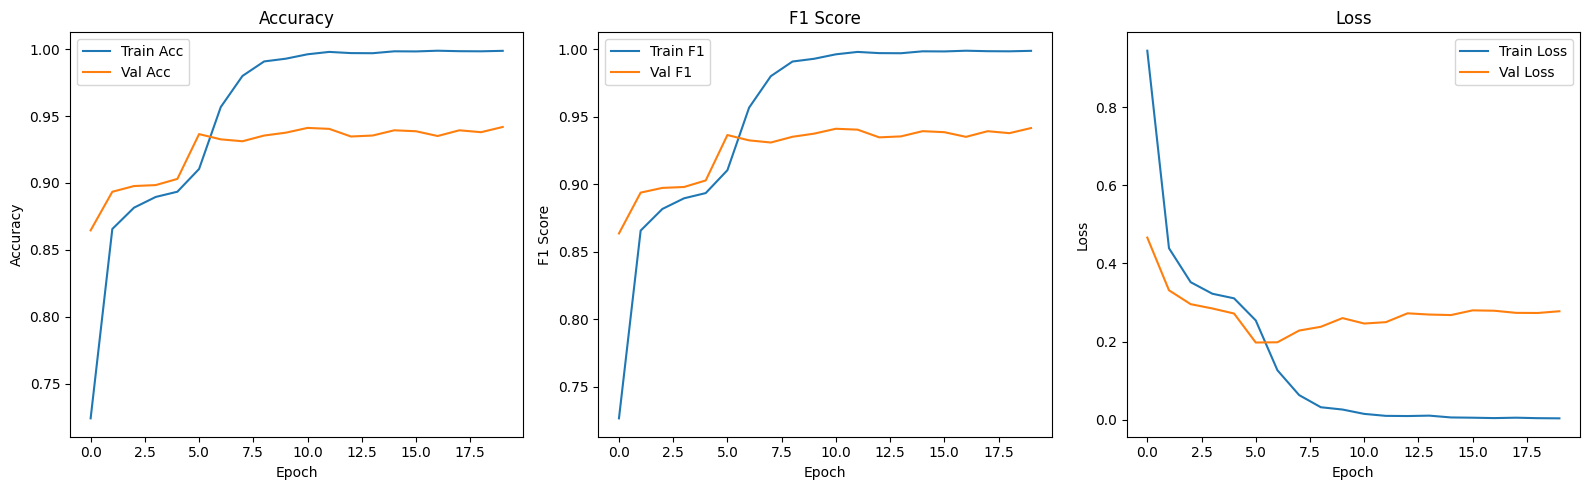

In [182]:
train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []
train_f1_hist, val_f1_hist = [], []
best_val_f1 = 0

for epoch in range(num_epochs):
    # augmentation phase
    if epoch < 5:
        train_dataset.transform = light_augment
        print("Using light augmentations (warm-up)")
    elif 5 <= epoch < 15:
        train_dataset.transform = heavy_augment
        print("Using heavy augmentations (main training)")
    else:
        train_dataset.transform = light_augment
        print("Using light augmentations (final tuning)")

    # Unfreezing schedule
    if epoch in unfreeze_schedule:
        unfreeze_block(model, unfreeze_schedule[epoch])
        print(f"Unfroze: {unfreeze_schedule[epoch]}")

    model.train()
    running_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)                       
        loss = loss_function(outputs, labels)          

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_f1 = f1_score(all_labels, all_preds, average='weighted')

    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    train_f1_hist.append(train_f1)

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    all_preds, all_labels, all_images = [], [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.extend(images.cpu())


    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)
    val_f1_hist.append(val_f1)

    scheduler.step(val_loss)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_dynamic.pth")

    print(f"Epoch [{epoch+1}/{num_epochs}] → "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}")

plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.plot(train_acc_hist, label='Train Acc')
plt.plot(val_acc_hist, label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_f1_hist, label='Train F1')
plt.plot(val_f1_hist, label='Val F1')
plt.title("F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

### More evaluation (of best-resnet model)

In [196]:
val_acc = accuracy_score(all_labels, all_preds)
val_f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"\nFinal Validation Accuracy: {val_acc:.4f}")
print(f"Final Validation F1 Score: {val_f1:.4f}\n")
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))


Final Validation Accuracy: 0.9380
Final Validation F1 Score: 0.9378

Classification Report:
               precision    recall  f1-score   support

   buildings       0.94      0.95      0.94       428
      forest       0.98      0.99      0.98       459
     glacier       0.92      0.86      0.89       472
    mountain       0.89      0.92      0.90       484
         sea       0.95      0.97      0.96       460
      street       0.95      0.94      0.95       503

    accuracy                           0.94      2806
   macro avg       0.94      0.94      0.94      2806
weighted avg       0.94      0.94      0.94      2806



confusion matrix

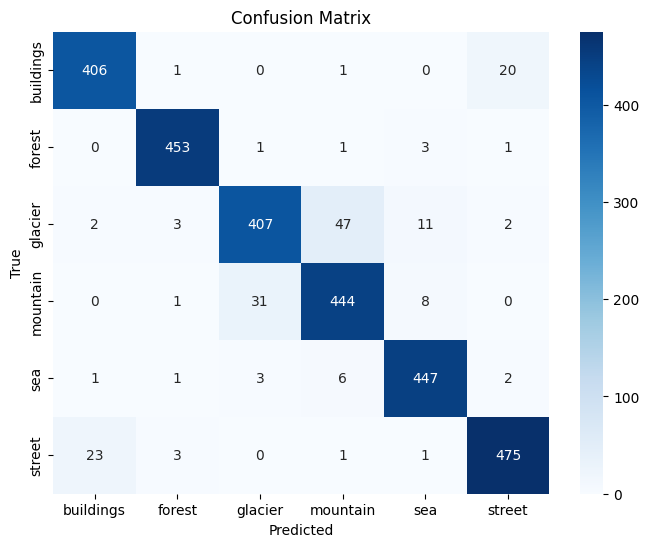

In [197]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Visualise missclassified images

misclassified imgs: 174


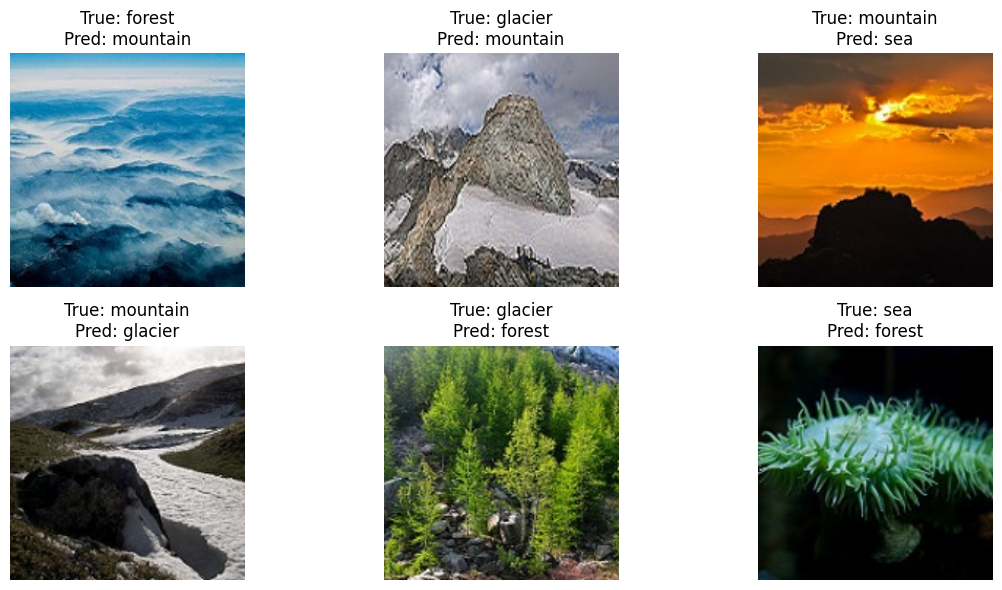

In [198]:
wrong_indices = [i for i, (p, l) in enumerate(zip(all_preds, all_labels)) if p != l]
print(f"misclassified imgs: {len(wrong_indices)}")

if wrong_indices:
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(wrong_indices[:6]):
        img = all_images[idx] * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        img = img.permute(1, 2, 0).clamp(0, 1)

        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[all_labels[idx]]}\nPred: {class_names[all_preds[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("no misclassifications found")

#### Test set evaluation !

In [199]:
num_classes = 6

resnet = models.resnet18(pretrained=False) 
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, num_classes)
)

model = resnet.to(device)
model.load_state_dict(torch.load("best_resnet.pth"))
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_31/1404615982.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [200]:
all_preds, all_labels = [], []
all_images = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating on test set"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_images.extend(images.cpu())

Evaluating on test set: 100%|██████████| 94/94 [00:07<00:00, 12.21it/s]



Classification Report:
              precision    recall  f1-score   support

   buildings       0.94      0.94      0.94       437
      forest       0.99      1.00      0.99       474
     glacier       0.91      0.87      0.89       553
    mountain       0.90      0.90      0.90       525
         sea       0.95      0.98      0.97       510
      street       0.95      0.95      0.95       501

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



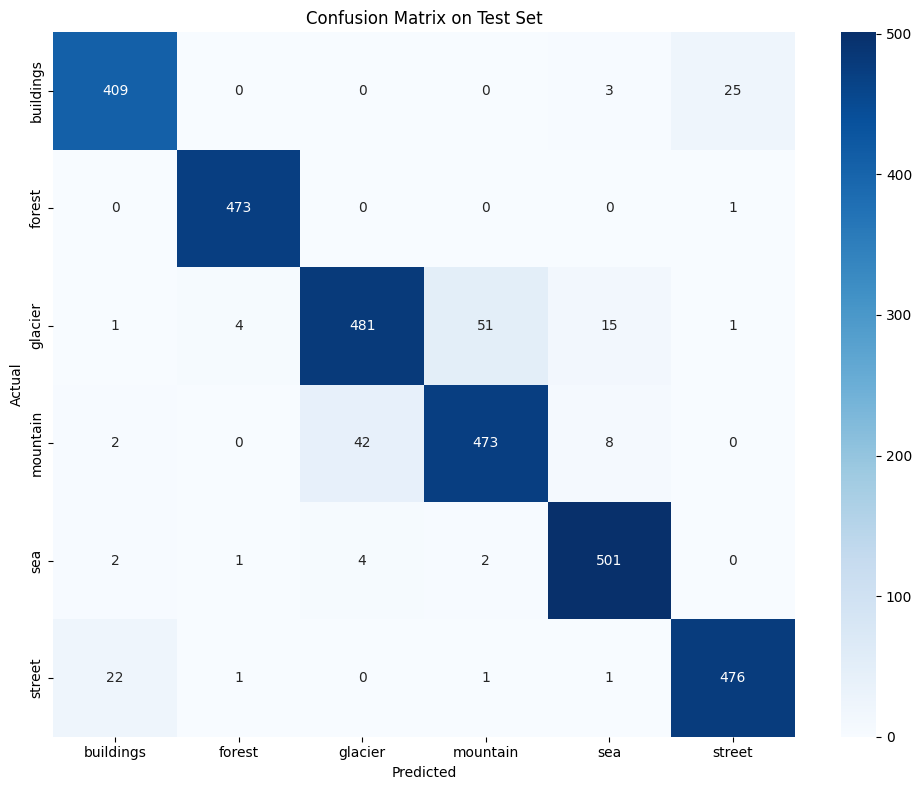


Test Accuracy: 0.9377
Test Weighted F1 Score: 0.9373


In [201]:
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Test Weighted F1 Score: {f1:.4f}")

### Conclusions

- Comparing ResNet to my manual CNN model, ResNet appeared more effective which was expected

- though it was suprising that ResNet model struggled with overfitting too , even when we adjusted last linear layer to have strionger regularisation

- ResNet model showed strong results, with a Test Accuracy of 0.9377 and a Weighted F1 Score of 0.9373

- Misclassifications occurred between visually similar classes such as forest vs. mountain, glacier vs. mountain, and sea vs. forest, so the model sometimes struggles to separate some textures, or color patterns.

### What Can Be Improved

Now the main task is to teach model capturing certain textures which it missclassified before, ideas: 

- Semantic-aware augmentation (domain-specific augmentations)

- Hard example mining (train directly on hard examples)

- self-attention (e.g., ResNet + CBAM, Vision Transformers)